#### Import packages ...

In [1]:
import sys
import matplotlib 
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.patches import FancyBboxPatch
import numpy as np
import networkx as nx

sys.path.append('../utils/')
sys.path.append('../libs/')
from curvygraph import *
from utils import rcPhysRev, c8, draw_process_motif, boldfont, sim

#### Set fonts for figures ...

In [2]:
%%capture
# some matplotlib configs to make labels pretty
rcPhysRev()

# define some font types
fontstandard= FontProperties()
fontbold = boldfont()

#### Define some functions for drawing figure elements ...

In [3]:
def boldtext(s):
    words = s.split(' ')
    out = ''
    for w in words:
        out += r'${\bf '+w+r'}$' + ' '
    out = out[:-1]
    return out

def drawFatArrow(p0,p1, ax=None, head_width=2.5, head_length=0.5, width=2, 
    length_includes_head=True, color='#a6d2ff', lw=1, ec='k', 
    **kwargs):
    if ax is None:
        ax = plt.gca()
    d = np.array(p1)-np.array(p0)
    arrow = mpatches.FancyArrow(p0[0],p0[1], d[0], d[1],
        width=width, color=color, lw=lw, ec=ec,
        head_width=head_width, head_length=head_length, 
        length_includes_head=length_includes_head, **kwargs)
    ax.add_patch(arrow)
    
def drawBox(p0, p1, ax=None, color='#ffe3e3', lw=1, ec='k', **kwargs):
    if ax is None:
        ax = plt.gca()
    d = np.array(p1)-np.array(p0)
    box = mpatches.Rectangle(p0, d[0], d[1], 
        color=color, lw=lw, ec=ec, **kwargs)    
    ax.add_patch(box)
    
def drawGraph(c, r, ax=None, colors=None, G=None, nodesize=300, arrowsize=20, 
    width=2, ec='k', aspect=1, nodepad_x=0.05, nodepad_y=0.1, rectangular=False, 
    draw=True, hide_edges=False):
    if ax is None:
        ax = plt.gca()
    if G is None:
        G = nx.DiGraph()
        G.add_nodes_from(range(6))
        G.add_edges_from([(5,2), (0,1), (0,3), (1,4), (1,2), (2,5), (3,2), (4,3), 
                          (5,4), (5,0)])
        if rectangular:
            G.add_edges_from([(1,0),(2,3),(3,1),(4,5)])
    if colors is None: 
        colors = ['#e69f00', '#019e73', '#f0e442', '#57b4e9', '#d55e00', 
                  '#0072b2']

    # make a dummy graph
    D = nx.Graph()
    D.add_edge(0,0)

    # make list of node positions
    if rectangular:
        pos_arr = np.array([[0,1],[2,1],[2,-1],[0,-1],[-2,-1],[-2,1]])
        pos_arr[:,1] = pos_arr[:,1]*aspect
        pos_arr = np.array(c)+r*pos_arr
    else:
        cos30, sin30 = np.sqrt(3)/2, 1/2
        pos_arr = np.array([[0,1],[cos30, sin30],[cos30,-sin30],
                            [0,-1],[-cos30,-sin30],[-cos30,sin30]])
        pos_arr[:,1] = pos_arr[:,1]*aspect
        pos_arr = np.array(c)+r*pos_arr
    
    if draw:
        # draw nodes
        for i in range(6):
            nx.draw_networkx_nodes(D, 
                pos={0: pos_arr[i]}, 
                node_color=colors[i], linewidths=1, edgecolors=ec, 
                node_size=nodesize)

        # draw edges
        if hide_edges:
            ecolor = 'Grey'
        else:
            ecolor = 'k'
        nx.draw_networkx_edges(G, pos={i: pos_arr[i] for i in range(6)}, 
                               width=width, arrowsize=arrowsize,
                               node_size=nodesize, edge_color=ecolor)

        if hide_edges:  
            x_arr = np.linspace(np.min(pos_arr[:,0])-nodepad_x, 
                                np.max(pos_arr[:,0])+nodepad_x, 200)[:-1]
            y0 = lambda x: (np.max(pos_arr[:,1])+nodepad_y 
                            if np.min(np.abs(pos_arr[:,0]-x))>nodepad_x 
                            else np.max(pos_arr[:,1])-nodepad_y)
            y1 = lambda x: (np.min(pos_arr[:,1])-nodepad_y 
                            if np.min(np.abs(pos_arr[:,0]-x))>nodepad_x 
                            else np.min(pos_arr[:,1])+nodepad_y)
            ax.fill_between(x_arr, [y0(x) for x in x_arr], 
                            y2=[y1(x) for x in x_arr], 
                            facecolor='Grey', alpha=0.75, zorder=10)

    return(G, pos_arr)

    
def add_fancy_patch_around(ax, pp, **kwargs):
    fancy = FancyBboxPatch((pp[0], pp[1]), pp[2], pp[3],
                           **kwargs)
    ax.add_patch(fancy)
    return fancy

#### Make some random data to use as time-series data example ...

In [4]:
%%capture
# make dummy data for schematic figure
G, _ = drawGraph((0,0),0, draw=False)
A = nx.adjacency_matrix(G).todense()
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
eps, sig, theta, dt = 0.9, 0.5, 1.0, 0.5
TS = sim(A, epsilon=eps, sigma=sig, ctime=1/theta, dt=dt, T=120, x0=None, normalize_adjacency=True)
TS = TS[:,20:]

# get edge likelihood scores
scores = (np.corrcoef(TS[:,1:], y=TS[:,:-1])[len(TS):,:len(TS)]
          - (1-theta*dt)*np.corrcoef(TS))
scores = scores-np.diag(np.diag(scores))
# cheating a bit here to make inferred graph match ground truth in the schematic
scores = scores+0.25*A 

#### Draw Figures ...
(Version 3 of this figure appears as Figure 1 in our paper.)

Draw version #1 ...

In [5]:
%%capture
# draw version 1 

dY, dy = 1.2, 0.2
dX = 1
textpad_x = 0.05
textpad_y = 0.1
label_size= 11
eq_size = 14

c6 = ['#e69f00', '#019e73', '#f0e442', '#57b4e9', '#d55e00', 
      '#0072b2']

plt.figure(figsize=(4,9))
ax = plt.subplot(111)
plt.xlim([-dX/2-textpad_x,3*dX/2+textpad_x])
plt.ylim([-7*(dY+dy)+dy-textpad_y,0.1])

# draw boxes
box_coords0 = [(-dX/2, -2*i*(dY+dy))for i in range(4)]
box_coords1 = [(3*dX/2,-(2*i+1)*(dY+dy)+dy) for i in range(4)]
box_labels = ['Unknown\nnetwork\nstructure', #Network with\nunknown\nstructure',
              'Time-\nseries\ndata',
              'PEM\nmatrix',
              'Inferred\nnetwork']

for i in range(4):
    drawBox(box_coords0[i],box_coords1[i], color='#dcffdb')
    plt.text(box_coords0[i][0]+textpad_x+dX/3,
             box_coords0[i][1]-dY/2,
             box_labels[i], size=label_size, ha='center', va='center')

# draw arrows
arr_coords0 = [(-dX/8,-(2*i+1)*(dY+dy)) for i in range(3)]
arr_coords1 = [(-dX/8,-(2*i+2)*(dY+dy)+dy) for i in range(3)]
arr_labels = ['Observe\ndynamics', 
              'Compute\nedge-like-\nlihood', 
              'Threshold\nPEM matrix']
for i in range(3):
    drawFatArrow(arr_coords0[i], arr_coords1[i], head_width=dX*0.75, width=dX*0.75)
    plt.text(-dX/8, #box_coords0[0]+textpad_x
             arr_coords0[i][1]-textpad_y,
             arr_labels[i], size=label_size, ha='center', va='top')

# add illustrations
r = 0.275
rr = 0.2
aspect=1.5
nodesize=90
rectangular=True

if rectangular:
    drawGraph((dX*0.9,-dY/2), rr, arrowsize=10, nodesize=nodesize, 
              width=1.5, rectangular=True, aspect=2, hide_edges=True) 
else:
    drawGraph((dX*1.1,-dY/2), r, arrowsize=10, nodesize=nodesize, 
              width=1.5, aspect=aspect)
    
if rectangular:
    drawGraph((0.825*dX,-1*(dY+dy)-dY/2), rr/1.35, arrowsize=10, nodesize=nodesize, 
              width=1.5, rectangular=True, aspect=2, hide_edges=True)     
    G, pos = drawGraph((0.825*dX,-1*(dY+dy)-dY/2), 2*rr/1.35, rectangular=True, 
                       aspect=2, draw=False)
else:
    drawGraph((dX,-1*(dY+dy)-dY/2), r, arrowsize=10, nodesize=nodesize, 
              width=1.5, aspect=aspect)
    G, pos = drawGraph((dX,-1*(dY+dy)-dY/2), 2.5*r,  
                       aspect=aspect, draw=False)
for i in range(6):
    dts_x = 0.225
    dts_y = 0.2
    ts0_x, ts0_y = pos[i]
    if i==1:
        ts0_x = ts0_x-0.175
        ts0_y = ts0_y-0.35
    elif i==2:
        ts0_x = ts0_x-0.15
        ts0_y = ts0_y+0.35
    elif i in [4,5]:
        ts0_x = ts0_x+0.15
    ts0_y = ts0_y - dts_y/2

    add_fancy_patch_around(ax, [ts0_x, ts0_y, dts_x, dts_y],
                           boxstyle="round,pad=0.03", fc='white', ec='k') #, **kwargs)    
    ts0 = ax.inset_axes([ts0_x, ts0_y, dts_x, dts_y], 
                        transform=ax.transData) 
    ts0.plot(TS[i][:20], color=c6[i]) #, color=c6[i])
    ts0.set_xticks([])
    ts0.set_yticks([])
    ts0.axis('off')

inset1 = ax.inset_axes([dX/4, -3*(dY+dy)+dy, dX*1.25, dY], 
                       transform=ax.transData)
for i in range(6):
    inset1.plot(10*TS[i]+8*i+2, color=c6[i])
inset1.set_ylim([-20,50])
arrow = mpatches.FancyArrow(1.2*dX/2,-3*(dY+dy)+dy+0.215, dX*0.5, 0, color='k', 
                            width=0.01, head_width=0.1, head_length=0.1)
ax.add_patch(arrow)
inset1.text(50,-9,'time', ha='center', va='top')
inset1.axis('off')

plt.text(0.4*dX+textpad_x, -4*(dY+dy)+dy+dY/2+0.25, 
         r'${\bf \Sigma}^{(k)}=\langle{\bf x}_{t+k}{\bf x}_t^T\rangle$',
         ha='left', size=eq_size)
plt.text(0.4*dX+textpad_x, -4*(dY+dy)+dy+dY/2-0.25, 
         r'${\bf S}={\bf \Sigma}^{(1)}-\delta{\bf \Sigma}^{(0)}$',
         ha='left', size=eq_size)

inset2 = ax.inset_axes([dX/16, -5*(dY+dy)+dy+textpad_y, dX, dY-2*textpad_y], 
                       transform=ax.transData)
inset2.imshow(scores, cmap='Greys')
inset2.set_xticks([])
inset2.set_yticks([])

inset2a = ax.inset_axes([dX, -5*(dY+dy)+dy+3*textpad_y, dX/2-textpad_x, dY-4*textpad_y], 
                       transform=ax.transData)
scores_list = np.sort(np.ravel(scores[scores>0]))
inset2a.plot(scores_list, np.arange(len(scores_list))[::-1]+1, 'k')
inset2a.set_xlabel('PEM')
inset2a.set_ylabel('cdf')
inset2a.set_xticks([])
inset2a.set_yticks([])
#inset2.axis('off')

inset3 = ax.inset_axes([dX/16, -6*(dY+dy)+dy+textpad_y, dX, dY-2*textpad_y], 
                       transform=ax.transData)
inf_adjacency = np.copy(scores)
thr = scores_list[-num_edges]
inf_adjacency[scores<thr] = 0.0
inf_adjacency[scores>=thr] = 1.0
inset3.imshow(inf_adjacency, cmap='Greys')
inset3.set_xticks([])
inset3.set_yticks([])

inset3a = ax.inset_axes([dX, -6*(dY+dy)+dy+3*textpad_y, dX/2-textpad_x, dY-4*textpad_y], 
                       transform=ax.transData)
cdf = np.arange(len(scores_list))[::-1]+1
cdf_x = scores_list
n = G.number_of_edges()
inset3a.plot(cdf_x[:-n],cdf[:-n],'k:')
inset3a.plot(cdf_x[-(n+1):],cdf[-(n+1):],'k')
inset3a.plot([cdf_x[-n],cdf_x[-n]],[0,max(cdf)],'r--')
inset3a.set_xlabel('PEM')
inset3a.set_ylabel('cdf', fontsize=9)
inset3a.set_xticks([])
inset3a.set_yticks([])

#inset3.axis('off')

if rectangular:
    drawGraph((dX*0.9,-6*(dY+dy)-dY/2), rr, arrowsize=10, nodesize=nodesize, 
              width=1.5, rectangular=True, aspect=2)     
else:
    drawGraph((dX*1.1,-6*(dY+dy)-dY/2), r, arrowsize=10, nodesize=nodesize, 
              width=1.5, aspect=aspect)

#ax.axis('off')

matplotlib.rc('text', usetex=False)
ax.text(dX*0.9,-dY/2-textpad_y/2, '?', color='white', ha='center', va='center',
        size=30, zorder=11, fontproperties=fontbold)
matplotlib.rc('text', usetex=True)
plt.savefig('../figures/figure1.pdf')

Draw version #2 ...

In [6]:
%%capture
# draw version 2

dY, dy = 1.2, 0.2
dX = 1
textpad_x = 0.05
textpad_y = 0.1
label_size= 9
eq_size = 9

c6 = ['#e69f00', '#019e73', '#f0e442', '#57b4e9', '#d55e00', 
      '#0072b2']

plt.figure(figsize=(4,9))
ax = plt.subplot(111)
xlims = [-dX/2-textpad_x,3*dX/2+textpad_x]
ylims = [-7*(dY+dy)+dy-textpad_y,0.1]
aspect_ratio = (ylims[1]-ylims[0])/(xlims[1]-xlims[0])
plt.xlim(xlims)
plt.ylim(ylims)

# draw boxes
box_coords0 = [(-dX/2, -2*i*(dY+dy))for i in range(4)]
box_coords1 = [(3*dX/2,-(2*i+1)*(dY+dy)+dy) for i in range(4)]
box_labels = [('Directed network\n' 
               +'with unknown\n'
               +'structure and\n'
               +r'${\bf non}$-${\bf Markovian}$'
               +'\nlinear dynamics'), #Network with\nunknown\nstructure',
              ('Time-series\ndata '+r'${\bf with}$'+'\n'
               +r'${\bf sampling}$'
               +'\n'+r'${\bf rate}$'
               +' $1/\Delta t$'),
              (r'Score matrix $\bf M$'+'\n'
               +r'of ${\bf correlation}$-'+'\n'
               +r'${\bf corrected}$'+'\n'
               +r'${\bf edge}$-${\bf likelihood}$'+'\n'
               +r'${\bf scores}$'),
              ('Inferred\nnetwork')]

for i in range(4):
    drawBox(box_coords0[i],box_coords1[i], color='#dcffdb')
    plt.text(box_coords0[i][0]+textpad_x+dX/3,
         box_coords0[i][1]-dY/2,
         box_labels[i], size=label_size, ha='center', va='center')
        
# draw arrows
arr_coords0 = [(-dX/8,-(2*i+1)*(dY+dy)) for i in range(3)]
arr_coords1 = [(-dX/8,-(2*i+2)*(dY+dy)+dy) for i in range(3)]
arr_labels = ['Observe\ndynamics\non nodes', 
              'Compute edge-\nlikelihood scores\nvia '+r'${\bf process}$'+'\n'+r'${\bf motifs}$',#from\ncrosscorrelation\nmatrices', 
              'Threshold\nedge-likelihood\nscores']
for i in range(3):
    drawFatArrow(arr_coords0[i], arr_coords1[i], head_width=dX*0.75, width=dX*0.75)
    plt.text(-dX/8, #box_coords0[0]+textpad_x
             arr_coords0[i][1]-dY/2+textpad_y,
             arr_labels[i], size=label_size, ha='center', va='center')

# add illustrations
r = 0.275
rr = 0.2
aspect=1.5
nodesize=90
rectangular=True

# add graph to box 1
if rectangular:
    drawGraph((dX*0.9,-dY/2), rr, arrowsize=10, nodesize=nodesize, 
              width=1.5, rectangular=True, aspect=2, hide_edges=True) 
else:
    drawGraph((dX*1.1,-dY/2), r, arrowsize=10, nodesize=nodesize, 
              width=1.5, aspect=aspect)
    
# add question mark to box 1 
matplotlib.rc('text', usetex=False)
ax.text(dX*0.9,-dY/2-textpad_y/2, '?', color='white', ha='center', va='center',
        size=30, zorder=11, fontproperties=fontbold)
matplotlib.rc('text', usetex=True)
    
# add graph to arrow 1
if rectangular:
    drawGraph((0.825*dX,-1*(dY+dy)-dY/2), rr/1.35, arrowsize=10, nodesize=nodesize, 
              width=1.5, rectangular=True, aspect=2, hide_edges=True)     
    G, pos = drawGraph((0.825*dX,-1*(dY+dy)-dY/2), 2*rr/1.35, rectangular=True, 
                       aspect=2, draw=False)
else:
    drawGraph((dX,-1*(dY+dy)-dY/2), r, arrowsize=10, nodesize=nodesize, 
              width=1.5, aspect=aspect)
    G, pos = drawGraph((dX,-1*(dY+dy)-dY/2), 2.5*r,  
                       aspect=aspect, draw=False)
    
# add boxes with time series to arrow 1
for i in range(6):
    dts_x = 0.225
    dts_y = 0.2
    ts0_x, ts0_y = pos[i]
    if i==1:
        ts0_x = ts0_x-0.175
        ts0_y = ts0_y-0.35
    elif i==2:
        ts0_x = ts0_x-0.15
        ts0_y = ts0_y+0.35
    elif i in [4,5]:
        ts0_x = ts0_x+0.15
    ts0_y = ts0_y - dts_y/2

    add_fancy_patch_around(ax, [ts0_x, ts0_y, dts_x, dts_y],
                           boxstyle="round,pad=0.03", fc='white', ec='k') #, **kwargs)    
    ts0 = ax.inset_axes([ts0_x, ts0_y, dts_x, dts_y], 
                        transform=ax.transData) 
    ts0.plot(TS[i][:20], color=c6[i]) #, color=c6[i])
    ts0.set_xticks([])
    ts0.set_yticks([])
    ts0.axis('off')

# add time series plot to box 2
inset1 = ax.inset_axes([dX/4, -3*(dY+dy)+dy, dX*1.25, dY], 
                       transform=ax.transData)
for i in range(6):
    inset1.plot(10*TS[i]+8*i+2, color=c6[i])
inset1.set_ylim([-18,50])
arrow = mpatches.FancyArrow(1.2*dX/2,-3*(dY+dy)+dy+0.22, dX*0.5, 0, color='k', 
                            width=0.01, head_width=0.1, head_length=0.1)
ax.add_patch(arrow)
inset1.text(50,-7,'time', ha='center', va='top')
inset1.axis('off')

# add process motif to arrow 2
inset2b = ax.inset_axes([dX/4+textpad_x, -3*(dY+dy)-2.2*dX+2*dy, 
                         1.2*dX, 2.1*dX], 
                         transform=ax.transData)
draw_process_motif(ax=inset2b, radius=0.4, node_radius=0.065, lim=0.55, fontsize=9, head_pad=0.015, set_limits=True)    

# add equations to arrow 2
plt.text(0.51*dX+textpad_x, -4*(dY+dy)+dy+dY/2+0.0, 
         r'${\bf \Sigma}^{(k)}=\langle{\bf x}_{t+k\Delta t}{\bf x}_t^T\rangle$',
         ha='left', size=eq_size)
plt.text(0.51*dX+textpad_x, -4*(dY+dy)+dy+dY/2-0.25, 
         r'${\bf S}={\bf \Sigma}^{(1)}-\delta{\bf \Sigma}^{(0)}$',
         ha='left', size=eq_size)

# add score matrix to box 3
inset2 = ax.inset_axes([dX/16, -5*(dY+dy)+dy+textpad_y, dX, dY-1.5*textpad_y], 
                       transform=ax.transData)
inset2.imshow(scores, cmap='Greys')
inset2.set_xticks([])
inset2.set_yticks([])

# add cdf to box 3
inset2a = ax.inset_axes([dX, -5*(dY+dy)+dy+2.5*textpad_y, dX/2-textpad_x, dY-3*textpad_y], 
                       transform=ax.transData)
scores_list = np.sort(np.ravel(scores[scores>0]))
inset2a.plot(scores_list, np.arange(len(scores_list))[::-1]+1, 'k')
inset2a.set_xlabel('score', labelpad=3)
inset2a.set_ylabel('cdf', labelpad=0)
inset2a.set_xticks([])
inset2a.set_yticks([])
#inset2.axis('off')

# add adjacency matrix to arrow 3
inset3 = ax.inset_axes([dX/16, -6*(dY+dy)+dy+textpad_y, dX, dY-1.5*textpad_y], 
                       transform=ax.transData)
inf_adjacency = np.copy(scores)
thr = scores_list[-num_edges]
inf_adjacency[scores<thr] = 0.0
inf_adjacency[scores>=thr] = 1.0
inset3.imshow(inf_adjacency, cmap='Greys')
inset3.set_xticks([])
inset3.set_yticks([])

# add cdf to arrow 3
inset3a = ax.inset_axes([dX, -6*(dY+dy)+dy+2.5*textpad_y, dX/2-textpad_x, dY-3*textpad_y], 
                       transform=ax.transData)
cdf = np.arange(len(scores_list))[::-1]+1
cdf_x = scores_list
n = G.number_of_edges()
inset3a.plot(cdf_x[:-n],cdf[:-n],'k:')
inset3a.plot(cdf_x[-(n+1):],cdf[-(n+1):],'k')
inset3a.plot([cdf_x[-n],cdf_x[-n]],[0,max(cdf)],'r--')
inset3a.set_xlabel('score', labelpad=3)
inset3a.set_ylabel('cdf', fontsize=9, labelpad=0)
inset3a.set_xticks([])
inset3a.set_yticks([])

# add graph to box 4
if rectangular:
    drawGraph((dX*0.9,-6*(dY+dy)-dY/2), rr, arrowsize=10, nodesize=nodesize, 
              width=1.5, rectangular=True, aspect=2)     
else:
    drawGraph((dX*1.1,-6*(dY+dy)-dY/2), r, arrowsize=10, nodesize=nodesize, 
              width=1.5, aspect=aspect)

#inset2b = ax.inset_axes([dX/2+textpad_x, -4*(dY+dy), 
#                         3*dY/aspect_ratio, 1.2*dY], 
#                         transform=ax.transData)
ax.axis('off')


plt.savefig('../figures/figure1-v2.pdf')

Draw version #3 ...

In [7]:
# some strings to be used in the figure
box_titles = [boldtext('Unknown network'), 
              boldtext('Time')+'-'+boldtext('series data'),
              boldtext('PEM matrix'),
              boldtext('Inferred network')]
box_labels = [('Directed, unweighted '+'\n' 
               +'network with unknown '+'\n' 
               +'structure and '+'\n'
               +'observable nodes'),
               #+'structure and Marko-'+'\n' 
               #+'vian or non-Markovian '+'\n' 
               #+'linear dynamics'),
              ('Realization of a linear '+'\n' 
               +'stochastic-difference '+'\n' 
               +'equation with inverse '+'\n' 
               +r'sampling rate $\Delta t$'),
              ('Linear combination '+'\n' 
               +'of correlation and '+'\n' 
               +'crosscorrelation '+'\n' 
               +'matrices'),
              ('Structure of a directed,'+'\n'
               +'unweighted network')]

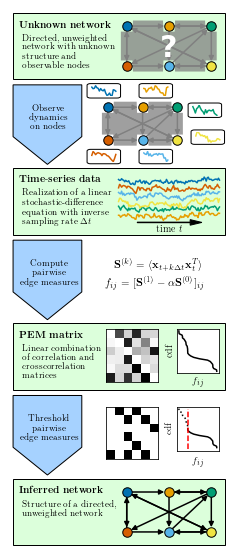

In [10]:
# draw version 3
dY, dy = 1.2, 0.2
dX = 0.9
textpad_x = 0.05
textpad_y = 0.1
label_size= 9
eq_size = 11

c6 = ['#e69f00', '#019e73', '#f0e442', '#57b4e9', '#d55e00', 
      '#0072b2']

plt.figure(figsize=(4,10))
ax = plt.subplot(111)
xlims = [-dX/2-textpad_x,3*dX/2+textpad_x]
ylims = [-7*(dY+dy)+dy-textpad_y,0.1]
aspect_ratio = (ylims[1]-ylims[0])/(xlims[1]-xlims[0])
plt.xlim(xlims)
plt.ylim(ylims)

# draw boxes
box_coords0 = [(-dX/2, -2*i*(dY+dy))for i in range(4)]
box_coords1 = [(3*dX/2,-(2*i+1)*(dY+dy)+dy) for i in range(4)]
title_height = 0.25

for i in range(4):
    drawBox(box_coords0[i],box_coords1[i], color='#dcffdb')
    plt.text(box_coords0[i][0]+textpad_x,#+dX/3-dX/3,
         box_coords0[i][1]-1.5*textpad_y,
         box_titles[i], size=label_size+1, ha='left', va='top')
    
    plt.text(box_coords0[i][0]+1.5*textpad_x,#+dX/3-dX/3,
         box_coords0[i][1]-1.5*textpad_y-title_height,
         box_labels[i], size=label_size, ha='left', va='top')
        
# draw arrows
arr_coords0 = [(-dX/8-0.05*dX,-(2*i+1)*(dY+dy)+dy/2) for i in range(3)]
arr_coords1 = [(-dX/8-0.05*dX,-(2*i+2)*(dY+dy)+dy/3) for i in range(3)]
arr_labels = [#'Observe\nMarkovian or\nnon-Markovian\ndynamics\non nodes', 
              'Observe\ndynamics\non nodes', 
              'Compute\npairwise\nedge measures',#from\ncrosscorrelation\nmatrices', 
              'Threshold\npairwise\nedge measures']
for i in range(3):
    drawFatArrow(arr_coords0[i], arr_coords1[i], head_width=dX*0.65, width=dX*0.65)
    plt.text(-dX/6, #box_coords0[0]+textpad_x
             arr_coords0[i][1]-dY/2,
             arr_labels[i], size=label_size, ha='center', va='center')

# add illustrations
r = 0.275
rr = 0.2
aspect=1.5
nodesize=90
rectangular=True

# add graph to box 1
if rectangular:
    drawGraph((dX*0.975,-dY/2-0), 0.9*rr, arrowsize=10, nodesize=nodesize, 
              width=1.5, rectangular=True, aspect=2, hide_edges=True) 
else:
    drawGraph((dX*1.1,-dY/2), 0.9*r, arrowsize=10, nodesize=nodesize, 
              width=1.5, aspect=aspect)
    
# add question mark to box 1 
matplotlib.rc('text', usetex=False)
ax.text(dX*0.975,-dY/2-textpad_y/2, '?', color='white', ha='center', va='center',
        size=30, zorder=11, fontproperties=fontbold)
matplotlib.rc('text', usetex=True)
    
# add graph to arrow 1
if rectangular:
    drawGraph((0.725*dX,-1*(dY+dy/2)-dY/2-textpad_y), rr/1.35, arrowsize=10, nodesize=nodesize, 
              width=1.5, rectangular=True, aspect=2, hide_edges=True)     
    G, pos = drawGraph((0.825*dX,-1*(dY+dy)-dY/2), 2*rr/1.35, rectangular=True, 
                       aspect=2, draw=False)
else:
    drawGraph((dX,-1*(dY+dy)-dY/2), r, arrowsize=10, nodesize=nodesize, 
              width=1.5, aspect=aspect)
    G, pos = drawGraph((dX,-1*(dY+dy)-dY/2), 2.5*r,  
                       aspect=aspect, draw=False)
    
# add boxes with time series to arrow 1
for i in range(6):
    dts_x = 0.225
    dts_y = 0.2
    ts0_x, ts0_y = pos[i]
    ts0_x = ts0_x-0.1*dX
    if i==1:
        ts0_x = ts0_x-0.175
        ts0_y = ts0_y-0.35
    elif i==2:
        ts0_x = ts0_x-0.15
        ts0_y = ts0_y+0.35
    elif i in [4,5]:
        ts0_x = ts0_x+0.15
    ts0_y = ts0_y - dts_y/2

    add_fancy_patch_around(ax, [ts0_x, ts0_y, dts_x, dts_y],
                           boxstyle="round,pad=0.03", fc='white', ec='k') #, **kwargs)    
    ts0 = ax.inset_axes([ts0_x, ts0_y, dts_x, dts_y], 
                        transform=ax.transData) 
    ts0.plot(TS[i][:20], color=c6[i]) #, color=c6[i])
    ts0.set_xticks([])
    ts0.set_yticks([])
    ts0.axis('off')

# add time series plot to box 2
inset1 = ax.inset_axes([dX/4+0.2*dX, -3*(dY+dy)+1.1*dy+0.02, dX*1.05, 0.9*dY], 
                       transform=ax.transData)
for i in range(6):
    inset1.plot(10*TS[i]+8*i+2, color=c6[i])
inset1.set_ylim([-18,50])
arrow = mpatches.FancyArrow(1.35*dX/2,-3*(dY+dy)+dy+0.22, dX*0.5, 0, color='k', 
                            width=0.01, head_width=0.1, head_length=0.1)
ax.add_patch(arrow)
inset1.text(50,-9.5, r'time $t$', ha='center', va='top')
inset1.axis('off')

## add process motif to arrow 2
if False:
    inset2b = ax.inset_axes([dX/4+textpad_x, -3*(dY+dy)-2.2*dX+2*dy, 
                             1.2*dX, 2.1*dX], 
                             transform=ax.transData)
    draw_process_motif(ax=inset2b, radius=0.4, node_radius=0.065, lim=0.55, fontsize=9, head_pad=0.015, set_limits=True)    

# add equations to arrow 2
plt.text(0.4*dX+textpad_x, -4*(dY+dy)+dy+dY/2+0.2, 
         #r'${\bf \Sigma}^{(k)}=\langle{\bf x}_{t+k\Delta t}{\bf x}_t^T\rangle$',
         r'${\bf S}^{(k)}=\langle{\bf x}_{t+k\Delta t}{\bf x}_t^T\rangle$',
         ha='left', size=eq_size)
plt.text(0.4*dX+textpad_x-0.08, -4*(dY+dy)+dy+dY/2-0.15, 
         #r'${\bf S}={\bf \Sigma}^{(1)}-\alpha{\bf \Sigma}^{(0)}$',
         r'$f_{ij}=[{\bf S}^{(1)}-\alpha{\bf S}^{(0)}]_{ij}$',
         ha='left', size=eq_size)

# add score matrix to box 3
inset2 = ax.inset_axes([2*dX/16, -5*(dY+dy)+dy+1.5*textpad_y, dX, dY-2.5*textpad_y], 
                       transform=ax.transData)
inset2.imshow(scores, cmap='Greys')
inset2.set_xticks([])
inset2.set_yticks([])

# add cdf to box 3
inset2a = ax.inset_axes([1.05*dX, -5*(dY+dy)+dy+3*textpad_y, 
                         0.45*dX-textpad_x, dY-4*textpad_y], 
                       transform=ax.transData)
scores_list = np.sort(np.ravel(scores[scores>0]))
inset2a.plot(scores_list, np.arange(len(scores_list))[::-1]+1, 'k')
inset2a.set_xlabel(r'$f_{ij}$', labelpad=0)
inset2a.set_ylabel('cdf', labelpad=0)
inset2a.set_xticks([])
inset2a.set_yticks([])
#inset2.axis('off')

# add adjacency matrix to arrow 3
inset3 = ax.inset_axes([2*dX/16, -6*(dY+dy)+dy+1.5*textpad_y, dX, dY-2.5*textpad_y],
                       transform=ax.transData)
inf_adjacency = np.copy(scores)
thr = scores_list[-num_edges]
inf_adjacency[scores<thr] = 0.0
inf_adjacency[scores>=thr] = 1.0
inset3.imshow(inf_adjacency, cmap='Greys')
inset3.set_xticks([])
inset3.set_yticks([])

# add cdf to arrow 3
inset3a = ax.inset_axes([1.05*dX, -6*(dY+dy)+dy+3*textpad_y, 
                         0.45*dX-textpad_x, dY-4*textpad_y],
                        #[dX, -6*(dY+dy)+dy+2.5*textpad_y, dX/2-textpad_x, dY-3*textpad_y], 
                       transform=ax.transData)
cdf = np.arange(len(scores_list))[::-1]+1
cdf_x = scores_list
n = G.number_of_edges()
inset3a.plot(cdf_x[:-n],cdf[:-n],'k:')
inset3a.plot(cdf_x[-(n+1):],cdf[-(n+1):],'k')
inset3a.plot([cdf_x[-n],cdf_x[-n]],[0,max(cdf)],'r--')
inset3a.set_xlabel(r'$f_{ij}$', labelpad=3)
inset3a.set_ylabel('cdf', fontsize=9, labelpad=0)
inset3a.set_xticks([])
inset3a.set_yticks([])

# add graph to box 4
if rectangular:
    drawGraph((dX*0.975,-6*(dY+dy)-dY/2), 0.9*rr, arrowsize=10, nodesize=nodesize, 
              width=1.5, rectangular=True, aspect=2)     
else:
    drawGraph((dX*1.1,-6*(dY+dy)-dY/2), r, arrowsize=10, nodesize=nodesize, 
              width=1.5, aspect=aspect)

#inset2b = ax.inset_axes([dX/2+textpad_x, -4*(dY+dy), 
#                         3*dY/aspect_ratio, 1.2*dY], 
#                         transform=ax.transData)
ax.axis('off')

plt.savefig('../figures/figure1-v3.pdf')